In [114]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [115]:
class MyDataset(Dataset):
    # 构造函数
    def __init__(self, data_tensor, target_tensor):
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
    # 返回数据集大小
    def __len__(self):
        return self.data_tensor.size(0)
    # 返回索引的数据与标签
    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

In [116]:
def map_array(arr):
    mapped_array = []
    for num in arr:
        if num == 0:
            mapped_array.append([1, 0])
        elif num == 1:
            mapped_array.append([0, 1])
    return mapped_array

In [117]:
from scipy.io import loadmat
file6 = "D:\\320 Deep-learning\data\\1118_S6_time1000.mat"
data6 = loadmat(file6)
file12 = "D:\\320 Deep-learning\data\\1111_S12_time1000.mat"
data12 = loadmat(file12)
file24 = "D:\\320 Deep-learning\data\\1111_S24_time1000.mat"
data24 = loadmat(file24)
""" experiment
X_train = data['Input']
X_train = torch.from_numpy(X_train).float()
y_train = data['Stability']
y_train = y_train.astype(np.float32) / 255
y_train = torch.tensor(y_train)
len_train = len(y_train)
X_test = data['PreInput']
X_test = torch.from_numpy(X_test).float()
y_test = data['PreSta']
y_test = y_test.astype(np.float32) / 255
y_test = torch.tensor(y_test)
len_test = len(y_test) """

#simulation
X6 = data6['Input_Abundance']
X6 = torch.from_numpy(X6).float()
y6 = data6['Stability']
y6 = torch.from_numpy(y6).float()

X12 = data12['Input_RelativeAbundance']
X12 = torch.from_numpy(X12).float()
y12 = data12['Stability']
y12 = torch.from_numpy(y12).float()

X24 = data24['Input_RelativeAbundance']
X24 = torch.from_numpy(X24).float()
y24= data24['Stability']
y24 = torch.from_numpy(y24).float()

t = 200
X_train = X6[0:t,:]
y_train = y6[0:t]
X_test = X6[t:1000,:]
y_test = y6[t:1000]

len_train = len(y_train)
len_test = len(y_test)

# 将数据封装成Dataset
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [118]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 10

""" 需不需要随机采样？ 随机采样和shuffle是不是一样的 """
""" # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers) """

# prepare data loaders
train_dataloader = DataLoader(dataset = train_dataset, # 传入的数据集, 必须参数
                               batch_size = batch_size,       # 输出的batch大小
                               shuffle = True,       # 数据是否打乱
                               num_workers = num_workers)      # 进程数, 0表示只有主进程
test_dataloader = DataLoader(dataset = test_dataset, # 传入的数据集, 必须参数
                               batch_size = batch_size,       # 输出的batch大小
                               shuffle = True,       # 数据是否打乱
                               num_workers = num_workers)      # 进程数, 0表示只有主进程

#for data,target in train_dataloader:
#    print(target.size(1))

In [119]:
import torch.nn as nn
import torch.nn.functional as F

# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(54, 2)
    def forward(self,x):
        #x = self.fc1(x) 
        x = F.sigmoid(self.fc1(x))
        return x

# initialize the NN
model = Net()
#print(model)

In [120]:
# specify loss function
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

tensor([[0.4775, 0.4815],
        [0.5170, 0.4455],
        [0.4734, 0.5114],
        [0.5314, 0.5073],
        [0.5356, 0.5018],
        [0.4817, 0.4997],
        [0.5008, 0.5250],
        [0.4702, 0.5182],
        [0.5353, 0.4586],
        [0.4876, 0.4693]], grad_fn=<SigmoidBackward0>)
tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 1])
tensor(0.6859, grad_fn=<NllLossBackward0>)
tensor([[0.5137, 0.4680],
        [0.4662, 0.4553],
        [0.4955, 0.4618],
        [0.5048, 0.4444],
        [0.5318, 0.4962],
        [0.5074, 0.4682],
        [0.5512, 0.4794],
        [0.5179, 0.4689],
        [0.5026, 0.5034],
        [0.4734, 0.4616]], grad_fn=<SigmoidBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
tensor(0.6804, grad_fn=<NllLossBackward0>)
tensor([[0.5039, 0.4547],
        [0.5265, 0.4368],
        [0.5353, 0.4940],
        [0.5012, 0.4336],
        [0.5453, 0.4837],
        [0.5319, 0.4551],
        [0.5033, 0.4653],
        [0.4902, 0.4832],
        [0.5313, 0.4374],
        [0.4757, 0.4848]

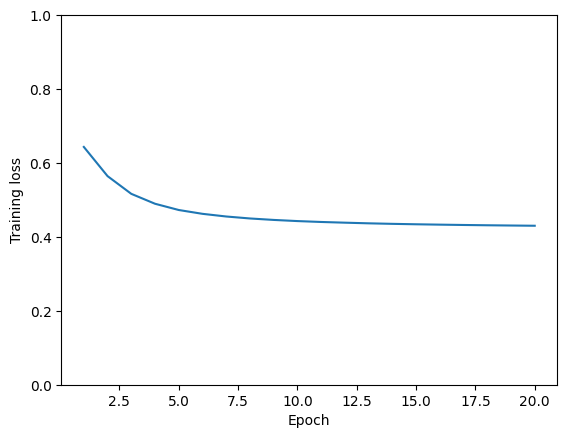

In [121]:
# number of epochs to train the model
n_epochs = 20
train_loss_min = np.Inf  # set initial "min" to infinity
train_loss_curve = list()

for epoch in range(n_epochs):
    train_loss = 0
    # train the model #
    loss = 0
    for data, target in train_dataloader: 
        optimizer.zero_grad()
        output = model(data)
        #make target a tensor:torch.Size([10]),dtype = long
        target = target.view(batch_size)
        target = target.long()
        #target = target.T
        loss = criterion(output,target)
        print(output)
        print(target)
        print(loss)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    # calculate average loss over an epoch
    train_loss = train_loss / len_train
    train_loss_curve.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
    
    # save model
    if train_loss <= train_loss_min:
        print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        train_loss_min,
        train_loss))
        torch.save(model.state_dict(), 'model.pt')
        train_loss_min = train_loss
plt.plot(np.linspace(1,n_epochs,n_epochs),train_loss_curve)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.ylim(0,1)
plt.show()